<a href="https://colab.research.google.com/github/katieprice14/computer-vision-system/blob/master/image_processing_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision System in Animal Science

Authors:
Katie Price (https://github.com/katieprice14)

Date: 3/16/2023

In [45]:
! pip install xlsxwriter
! pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Set up the Google Colab Enviornment

In [46]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Change this code to fit your working directory

## Import Python Libraries

In [47]:
#Image processing libraries
from ctypes.wintypes import RGB
import numpy as np
import pandas as pd
from audioop import avg
import cv2
from PIL import Image

#Statistics Library
from audioop import avg
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
from scipy import stats
import statistics
import xlsxwriter
import math
from google.colab.patches import cv2_imshow

#Moving through directoriess
from importlib.resources import path

## Iterating through Libraries
Directory Architecture


*   Main Directory
  * Cow_ID1
      * Cow_image1.png
      * Cow_image1.csv
      * Cow_image2.png
      * Cow_image2.csv
      *...
  * Cow_ID2
      * Cow_image1.png
      * Cow_image1.csv
      * Cow_image2.png
      * Cow_image2.csv
      *...
  *...

The code walks through the main directory, and creates the path for the subdirectories (1 subdirectory per cow ID). It then find the .png and .csv files in the subdirectory and adds their base name to the list.




In [48]:
directory = r"/content/drive/MyDrive/directory"

#Iterate through the directoires in the main directory
for root, dirs, files in os.walk(directory): #Checks everthing listed in directory

    #find any of the subfolders within
    for dir in dirs: #find all the subdirectories within larger parent directory
        subdir = os.path.join(directory, dir)
        images = [x for x in os.listdir(subdir) if ".png"]
        csvs = [x for x in os.listdir(subdir) if ".xlsx"]

        #Initialize the data lists
        img_list = []
        csv_list = []

        for img in images:
            img_name = str(img.removesuffix(".png"))
            img_list.append(img_name)
        for csv in csvs:
            csv_name = str(csv.removesuffix(".csv"))
            # add the csv file to the csv list
            csv_list.append(csv_name)

## Initializing
Initalized Lists for body weight factors and sets up a excel sheet to print the results

In [49]:
        length_list = []
        width_list = []
        depth_list = []
        volume_list = []  
        
        #Set up a excel file and sheet
        workbook = xlsxwriter.Workbook(str(os.path.basename(subdir))+'.xlsx')
        worksheet = workbook.add_worksheet()
        worksheet.write('A1', 'Length')
        worksheet.write('B1', 'Width')
        worksheet.write('C1', 'Height')
 

0

## Check and Read Files

Iterates through each image and csv file and ensures they have the same base name.
Reads the csv and image files.

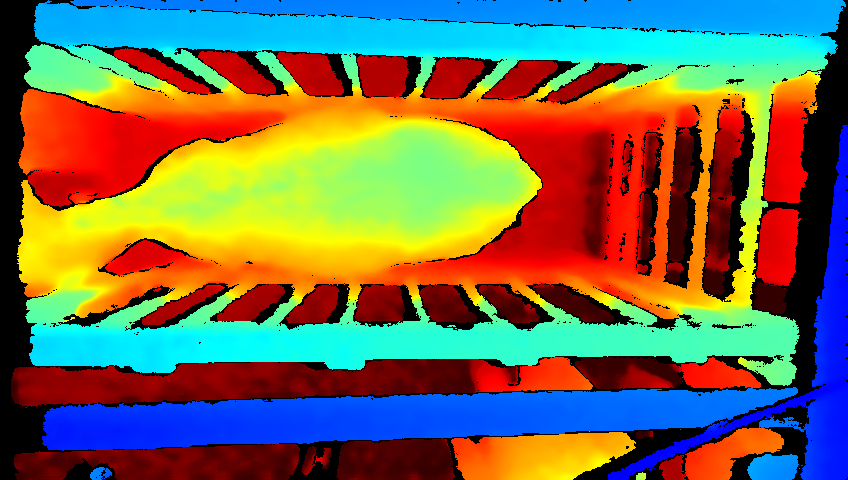

In [50]:
        for img_name in img_list:
            for csv_name in csv_list:
                if img_name == csv_name:

                    #reconstruct csv and img paths    
                    csv_img = pd.read_csv(str(os.path.join(subdir,csv_name)) + '.csv', header = None, engine ='python')
                    img = cv2.imread(str(os.path.join(subdir,csv_name)) + '.png')
                    cv2_imshow(img)                

## Convert to the HSV (Hue, Saturation, Value) color scale

In general, the HSV color scale works well to separate the cow from the background.

The HSV color scale has three channels (hue, saturation, value).

The Hue value shows the best differentiation between the cow and the background, so we will begin our extraction with that value.

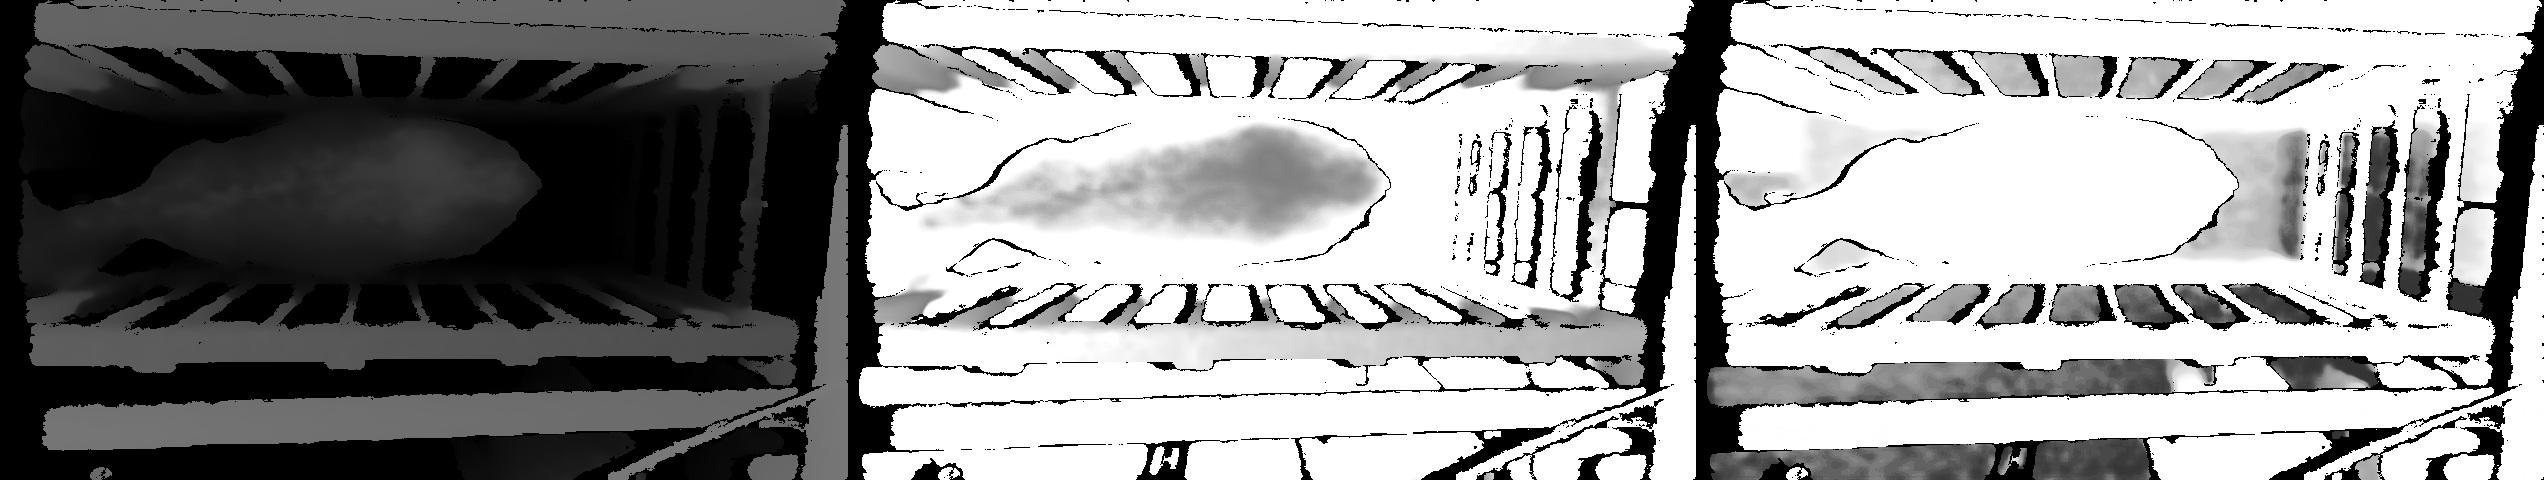

In [51]:
                    #COnvert to hue, saturation, and value, and split the images
                    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                    h,s,v = cv2.split(hsv_img)
                    hsv_split = np.concatenate((h,s,v),axis=1)
                    cv2_imshow(hsv_split)

## Image thresholding
We will use the hue of 20 for the threshold.

Using a kernel of size (49,49), we erode the image to extract the largest mass in the image


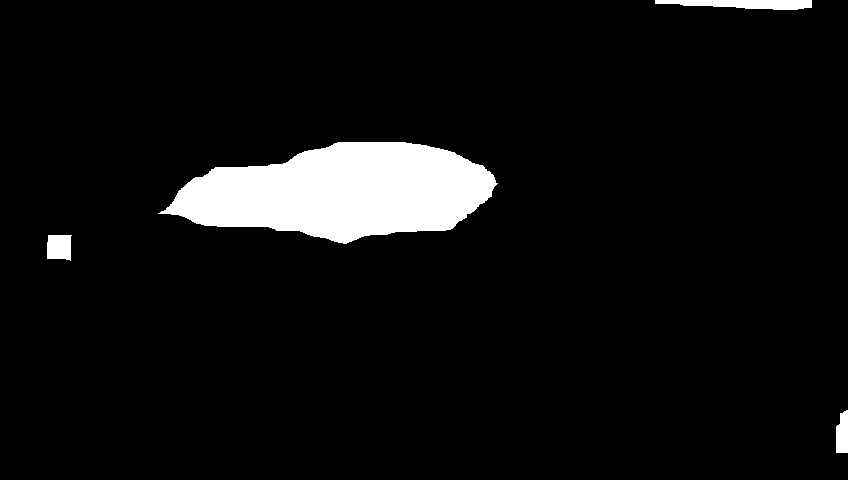

In [54]:

                    # Use the hue image to convert to binary
                    thresh = 20 #thresh hold for converting into black or white
                    thresh, thresh_img = cv2.threshold(h, thresh, 255, cv2.THRESH_BINARY)
              
                    # Erode the image to seperate the head and neck
                    kernel = np.ones((49,49), np.uint8) #determines the size of the matrix to extract the images
                    img_erosion = cv2.erode(thresh_img, kernel, iterations=1)
                    cv2_imshow(img_erosion)

## Find contours in the image

Because the findContours function will edit (change) the original image, we use thresh_img.copy(). 

The variable cnts stores coordinates of all the shapes. The variable c includes the coordinates of the largest shape (area).

Note tha each individual contour returned by the findContours function is a Numpy array of (x,y) coordinates of boundary points of the object, rather than (cY, CX).

In [55]:
                    #Finds all the contours in the image
                    # Use a copy of the image since findContours alters the image
                    contours, hierarchy = cv2.findContours(img_erosion.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                    print(f"There are {len(contours)} countorus (shapes) in total \n")
                    
                    #Extract the largest contour area
                    c = max(contours, key=cv2.contourArea)
                    print("The largest area is (number of pixels): ", cv2.contourArea(c)) 

There are 4 countorus (shapes) in total 

The largest area is (number of pixels):  22627.0


## Segment and Re-Dilate
To segment the cow (the largest area) and fill the holes in the cow image, we will create a mask. A mask is a black image with the size equal to the cow image. Then we draw the contour of the cow on the masked image.

We will then find the contours of the redilated images.

The process of eroding and dilating removes background information and the head of the cow, just leaving the biggest mass (the body).

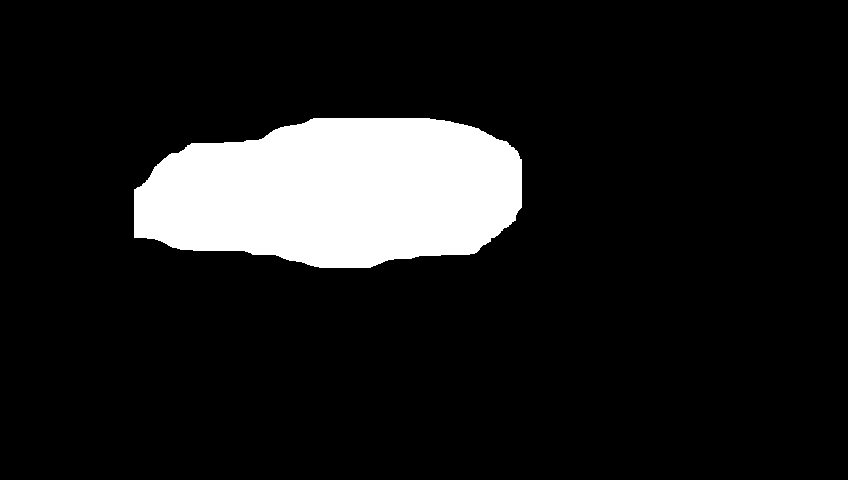

In [57]:
                    #draws the largest contour back onto the image
                    mask = np.zeros(img_erosion.shape, dtype=img_erosion.dtype)
                    drawing = cv2.drawContours(mask, [c], 0, (255), -1)


                    #re-dilate the image after finding the largest area to get just the body
                    img_dilation = cv2.dilate(drawing, kernel, iterations=1)
                    cv2_imshow(img_dilation)
                    # Find the contours of the redilated images (the redilated image is just the body)
                    contours2 = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    contours2 = contours2[0] if len(contours2) == 2 else contours2[1]

## Estimating Length and Width

Draw a bonding box around the cow at the widest and longest points, then find the length and width.

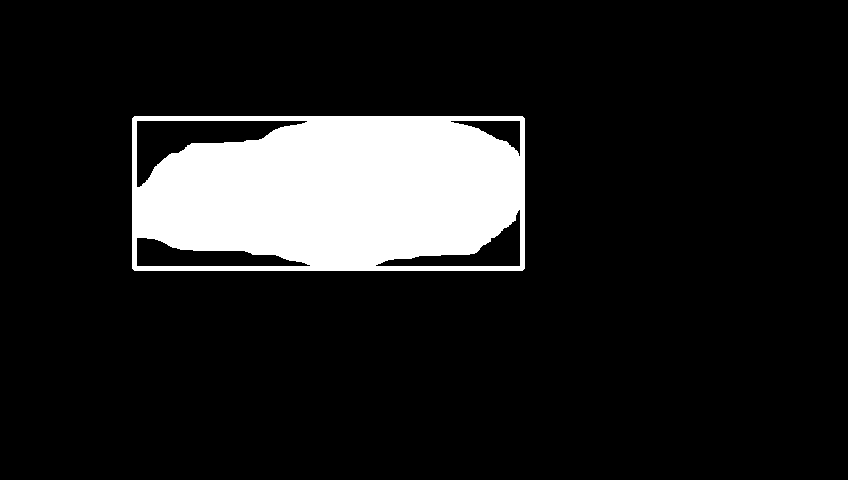

In [63]:

                    #Draw the bonding rectangle around the body
                    for i in contours2:
                          x,y,Length,Width = cv2.boundingRect(i)
                          cv2.rectangle(img_dilation, (x, y), (x + Length, y + Width), (255,0,0), 4)

                    cv2_imshow(img_dilation)
                    
                    #adds the length and width from the images to the length and width list
                    length_list.append(Length)
                    width_list.append(Width)

## Finding the Volume


We will summarize the distances (values) in the CSV file.

We will obtain the coordinates of the segmented image. The pixel object includes (y, x) information (the origin is the top left).

Create a new variable csv_img_rows including col, row, and distance.
This new variable will set up a "table" with the first column being row, the second column being column, and the last row being distance.

It will iterate through each pixel in the csv file to find the summary statistics for each image

In [64]:
                    #Get the coordinates of the segmented image and print the pixels
                    stats.describe(np.ravel(drawing)) #returns a 1 Dimentional array
                    pixel = np.argwhere(drawing == 255) #finds where the image is white (cow)
                    pixel[0:4,]

                    csv_img_rows = []
                    for row, col in pixel[0:480,0:848]:
                        csv_img_rows.append([row, col, csv_img.iloc[row,col]])#finds the row and column values of the cow

## Converting and Finding Outliers

In [65]:
                    #Convert the variable to a pandas data frame - easier to remove outliers
                    df = pd.DataFrame(csv_img_rows, columns = ['row', 'col', 'dist'])
                    df.describe()
                    print(df.shape)
                    print(df.head())

                    #Remove the outliers
                    df.dist.replace(to_replace=0, value = df.dist.mean(), inplace=True)

(480, 3)
   row  col   dist
0  142  337  1.292
1  142  338  1.289
2  142  339  1.289
3  142  340  1.287
4  142  341  1.287


## Finding the Heigth and Volume
Estimate the cows height using the average from the pandas data frame.

Sum all the height values to estimate the volume.

Add both of these values to the depth and volume lists.

In [ ]:
                    #Use the median to find the average
                    distMean = df.dist.median()
                    height = 2.5 - distMean

                    #Add value to the depth list
                    depth_list.append(height)

                    #calculating volume by finding the sum of all the heights in the white (cow) area
                    df["height"] = 2.5 - df["dist"]
                    volume = sum(df.height)
                    volume_list.append(volume)
                else:
                  pass                    

## Writing in Excel

Initialize each of the rows to the second row (index 1)

Iterate through each item in the depth, length, width, and volume list and add the value to the excel sheet.

The row number will increase after each iteration.


In [ ]:
        #Initialize the rows in excel file
        d_row = 1
        w_row = 1
        l_row = 1
        v_row = 1

        #Interate through each list, and add the number to the excel sheet
        for item in depth_list:
            worksheet.write_number(d_row,2,item)
            d_row += 1
        for item in width_list:
            worksheet.write_number(w_row,1,item)
            w_row += 1
        for item in length_list:
            worksheet.write_number(l_row,0,item)
            l_row += 1
        for item in volume_list:
            worksheet.write_number(v_row,3,item)
            v_row += 1

## Create Column Headers and Statistical Analysis

In [ ]:
        #Find the median of these values and put them in the excel file
        #Create headers for the columns in excel
        worksheet.write('F1','Median Width in Pixels')
        worksheet.write('G1','Median Length in Pixels')
        worksheet.write('H1','Mean Depth')
        worksheet.write('I1', 'Median Depth')
        worksheet.write('J1', 'Average Volume')

        #writes the mean, median, and volume values into the excel sheet
        
        worksheet.write_number('F2', statistics.median(width_list))
        worksheet.write_number('G2', statistics.median(length_list))
        worksheet.write_number('H2', statistics.mean(depth_list))
        worksheet.write_number('I2', statistics.median(depth_list))
        worksheet.write_number('J2', statistics.median(volume_list))

        #close the worksheet
        workbook.close()